# Cuaderno 21: Problema del agente viajero asimétrico (ATSP)

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* consiste en encontrar un circuito que visite **todos** los nodos de $D$ y que tenga el menor costo posible.

Utilizando variables binarias $x_{ij}$ para indicar la selección de arcos en el circuito, el problema del agente viajero puede formularse como el siguiente programa lineal entero:

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(j, i) \in A} x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{(i, j) \in A} x_{ij} = 1, \quad \forall i \in V,\\ 
&\sum_{(i,j) \in E(W)} x_{ij} \leq \card{W} - 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A.
\end{align*}
donde $E(W) := \{ (i,j) \in A \, : \, i \in W, j \in W\}$.

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` para generar puntos con coordenadas aleatorias en el rango {0,..,100}. El costo de un arco $(i,j)$ será igual a la distancia euclideana entre $i$ y $j$:

In [1]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 10

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()


Vamos a necesitar construir una restricción de eliminación de subciclos para cada subconjunto de nodos $W \subset V$ tal que $\emptyset \neq W \neq V$. Con esta finalidad, definimos una función `powerset` empleando las funciones `chain` y `combinations` del módulo `itertools`.

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


Definimos ahora el objeto modelo, las variables y la función objetivo:

In [4]:
# Crear el objeto modelo
m = Model('tsp')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado:

In [5]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
# Restricciones de grado entrante
m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

Para construir las restricciones de subciclos, usamos la función `powerset` para iterar sobre todos los subconjuntos de vértices $W$ tales que $\emptyset \neq W \neq V$. Para cada subconjunto, la expresión `x.sum(W, W)` construye la suma de las variables asociadas a arcos con ambos extremos en $W$.

In [6]:
# Restricciones de eliminacion de subciclos
for W in powerset(V):
    if W!=() and W!=tuple(V):
        m.addConstr(x.sum(W, W) <= len(W)-1, "subciclo[{}]".format(W))


Escribimos el modelo a un archivo de texto:

In [7]:
# Escribir el modelo a un archivo
m.write('tsp.lp')


Finalmente, resolvemos el modelo y mostramos la solución:

In [8]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] >= 0.99:
            print('{} -> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1042 rows, 90 columns and 23130 nonzeros
Model fingerprint: 0xb25cc7f4
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 439.9170410
Presolve removed 10 rows and 0 columns
Presolve time: 0.16s
Presolved: 1032 rows, 90 columns, 23130 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 3.352127e+02, 40 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     335.2126826  335.21268  0.00%     -    0s

Explored 0 nodes (40 simplex iterations) in 0.53 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 335.213 

## Bonus extra

### Graficando los toures con matplotlib

Podemos emplear el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [9]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Utilicemos ahora esta función para graficar la solución de nuestra instancia:

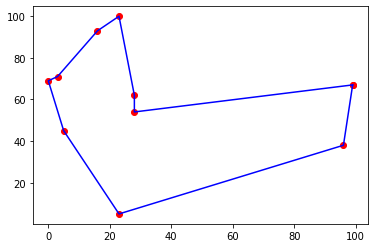

In [10]:
# Crear lista con arcos seleccionados en la solucion
L = [(i,j) for i,j in A if vx[i,j]>0]

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    j = [j for j in V if (i,j) in L].pop()
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 65566 rows, 240 columns and 3932400 nonzeros
Model fingerprint: 0xde05c8b2
Variable types: 0 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 942.8519348
Presolve removed 16 rows and 0 columns (presolve time = 5s) ...
Presolve removed 16 rows and 0 columns (presolve time = 12s) ...
Presolve removed 16 rows and 0 columns
Presolve time: 13.60s
Presolved: 65550 rows, 240 columns, 3932400 nonzeros
Variable types: 0 continuous, 240 integer (240 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   3.200000e+01     17s
      44    3.5666066e+02   0.000000e+00   0.000000e+00     17s
      44    3.5666066e+02   0.000000e+00   0.000000e+00     17s

Root rel

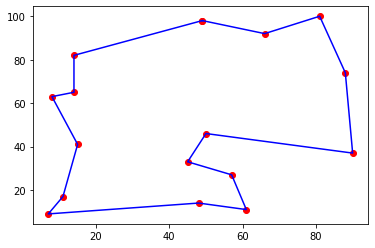

In [14]:
# Implementación de modelos lineales enteros
# Problema del agente viajero (TSP)

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 16

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('tsp')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

    # Restricciones de eliminacion de subciclos
    PV = list(powerset(V))
    for W in PV:
        if W!=() and W!=tuple(V):
            m.addConstr(x.sum(W, W) <= len(W)-1, 
                        "subciclo[{}]".format(W))

    # Escribir el modelo a un archivo
    # m.write('tsp.lp')

    # Calcular la solucion optima
    m.optimize()

    # Escribir la solucion
    if m.status == GRB.Status.OPTIMAL:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in A if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos
    T = [1]
    # nodo actual:
    i = 1
    while True:
        # Determinar sucesor de i
        j = [j for j in V if (i,j) in L].pop()
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        # Terminar cuando el nodo colocado sea 1
        if i==1: break;
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    
    
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')

### Creando el conjunto potencia de un conjunto en Python

Para construir el conjunto potencia (la familia de subconjuntos) de cualquier iterable, pueden usarse las funciones `chain` y `combinations` del módulo `itertools`.

In [23]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

V = tuplelist([1, 2, 3, 4, 5])
L = list(powerset(V))
print("V= {}".format(V))
print("L= {}".format(L))

for W in L:
    if W!=() and W!=tuple(V):
        print (W, len(W))

V= [1, 2, 3, 4, 5]
L= [(), (1,), (2,), (3,), (4,), (5,), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (1, 2, 3, 4, 5)]
(1,) 1
(2,) 1
(3,) 1
(4,) 1
(5,) 1
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 4) 2
(3, 5) 2
(4, 5) 2
(1, 2, 3) 3
(1, 2, 4) 3
(1, 2, 5) 3
(1, 3, 4) 3
(1, 3, 5) 3
(1, 4, 5) 3
(2, 3, 4) 3
(2, 3, 5) 3
(2, 4, 5) 3
(3, 4, 5) 3
(1, 2, 3, 4) 4
(1, 2, 3, 5) 4
(1, 2, 4, 5) 4
(1, 3, 4, 5) 4
(2, 3, 4, 5) 4


In [3]:
L = list(powerset([1,3,5,7]))
print(L)

[(), (1,), (3,), (5,), (7,), (1, 3), (1, 5), (1, 7), (3, 5), (3, 7), (5, 7), (1, 3, 5), (1, 3, 7), (1, 5, 7), (3, 5, 7), (1, 3, 5, 7)]
